In [1]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk
import evtk

from scipy.interpolate import griddata

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[ 50,50,50],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points2.csv")
geo_data.n_faults = 1

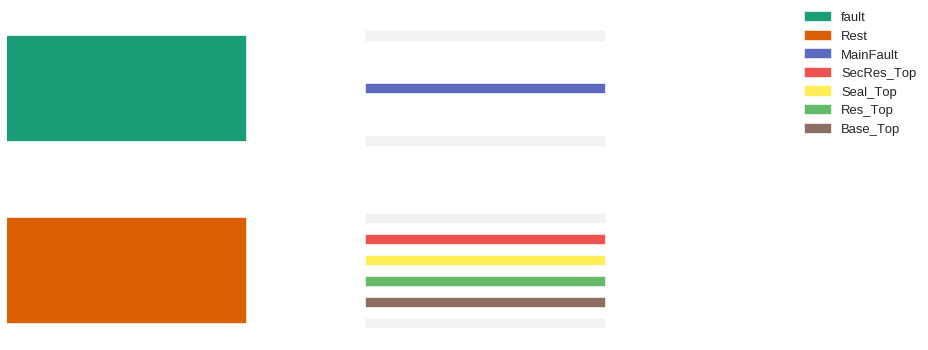

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ]) #for Fab_Test

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

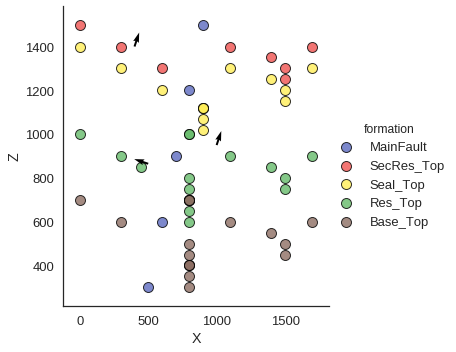

In [5]:
gp.plot_data(geo_data)

In [6]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [7]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1388747143310536e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [8]:
array_shapeholder=np.zeros_like(lith_sol)

In [9]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))

In [9]:
# 3D plot points in VTK
gp.plot_data_3D(geo_data)

In [14]:
# 3D plot points and surfaces in VTK
gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

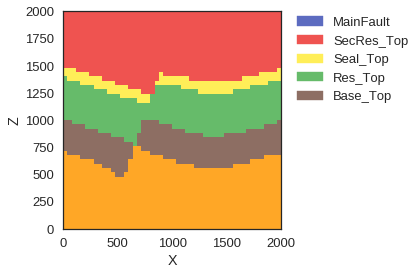

In [10]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0], 25, plot_data=0)

In [11]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

In [12]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [13]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to a separate "formation", to make sure the separation from border is given
# (the voxels are located on the border of reservoir and seal) (???):
#def set_spill_to_seal(geo_data, lith, max_z):
#    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]-np.abs(max_z)))
#    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
#    lith[bol_lith_spill] = 11 #for 11 instead of seal, to check - interp_data.get_formation_number()['Res_Top']
#    return lith
    # problem: this interferes with information entropy analysis
    # ideally, only trap border voxels would be altered, or possibly only one voxel necessary? How?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault, fault_seal):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad, 1)
    #G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_compute(geo_data, lith_pad, fault_pad)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    secres_keys = [int(j) for j in topo.lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in topo.lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in trap_keys:
        #print('Checking Section:', tk)
        juxta_counter = 0
        # Check for adjacency to model border
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            # Check for connection (juxtaposition!) to overlying layers (above seal)
            if fault_seal == False: # if fault is sealing, juxtaposition is irrelevant
                for ok in tot_over_keys:                    
                    if topo.check_adjacency(tk, ok) == True: # check for juxtaposition
                        print('JP found Trap section %s to overlying section %s.' % (tk, ok))
                        juxta_counter += 1
                if juxta_counter == 0:
                    traps.append(tk) # TRAP is accepted, no JP, no connection to border
                    print("No JP. TRAP FOUND, section:", tk)
                else:
                    print('Trap %s is juxtaposed --> leaking' % tk) # possible TRAP is discarded due to JP
            else:
                print("Fault SEALING, JP irrelevant. TRAP FOUND, section:", tk) 
                traps.append(tk) # TRAP accepted, no check for JP necessary, no connection to border
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    return trap_mask    # this mask returns True for all voxels which were accepted as trap voxels

In [14]:
### ATTEMPT TO COME UP WITH SINGLE FUNCTION FOR JUXTAPOSITION AT THE BEGINNING STAGE OF FINDING RIGHT SPILL POINT
#def juxtaposition_over_seal(lith, fault):
#    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_compute(geo_data, lith, fault)
#    res_nr = interp_data.get_formation_number()['Base_Top']
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    res_keys = [int(k) for k in lith_to_labels_lot["%s" % res_nr].keys()]
#    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()]
#    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()]
#    tot_over_keys = np.append(secres_keys, over_keys)
#    #print(res_keys)
#    #print(tot_over_keys)
#    top_counter = 0
#    gp.plot_section(geo_data, lith, 0)
#    gp.topology_plot(geo_data, G, centroids)
#    for rk in res_keys:
#        print('Checking for juxtapositions with overlying permeable layers for section:', rk)
#        # Saving enclosed sections as traps
#        for ok in tot_over_keys:
#            if gp.topology_check_adjacency(G, rk, ok) == True:
#                if G.adj[rk][ok]['edge_type'] == 'fault':
#                    top_counter += 1
#                    print("Juxtaposition of reservoir formation found:", rk, ok)
#            else:
#                print("No juxtaposition found!")
#    if top_counter == 0:
#        return False
#    else:
#        return True

In [15]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing):
    
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        if fault_sealing == True:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is sealing. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                max_z = spill_z
                print("...but fault sealing. Down to spill.")
                #bottom_surface = spill_bottom
        else:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is pathway. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                print("Cross-fault leakage. Down to leak.")
                #bottom_surface = leak_bottom      
        
        #print('Max_Z:', max_z)
        res_nr = lith == interp_data.get_formation_number()['Base_Top']
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            return 0, lith, bottom_surface, pre_trap_mask
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                                # (incl. outside trap) to formation value = 7  
            #if max_z == spill_z:
            #lith = set_spill_to_seal(geo_data, lith, max_z)
            
            #test = lith.reshape(125000)                       
            #for i in range(len(test)):                         #to test pre-trap-masking volume
            #    if test[i] == 7:
            #        vol_cells +=1
            #res_vol = ((scale_factor)**3) * vol_cells 
            #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
            
            final_trap_mask = topo_analysis(lith, fault, fault_sealing)
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask

In [16]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [23]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 20 #* unc_f
std_seal_top = 30 #* unc_f
std_res_top = 60 #* unc_f
std_base_top = 80 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 60
offset_unc = pymc.Normal('offset_unc', -20/rescale_f, 1./np.square(std_offset/rescale_f))

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.25)

In [24]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

Z variations top to bottom: 13.2725660031 68.2419174923 -29.9929854326 -31.5371213899
Fault offset variation: 7.62341684095
Fault sealing = True


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Serie

Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2701
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3247
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2312
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2866
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2631
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3762
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2694
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3659
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2702
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3607
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3001
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3346
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3473
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3307
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3355
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3775
Fault SEALING, JP irrelevant. TRAP FOUND, sec

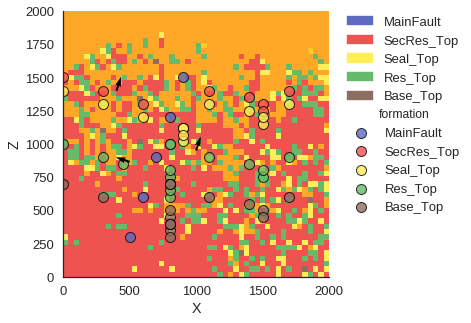

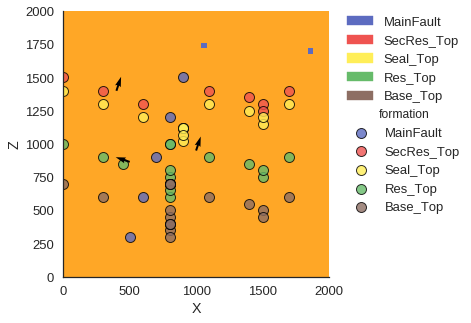

In [25]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc
    
    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, ash=array_shapeholder, print_figures=True):
    print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing)
        print("Maximum reservoir volume: %s m³" % max_vol)
        #gp.plot_section(geo_data, lith_sol[0,0], 5, plot_data =1)
        #gp.plot_section(geo_data, lith_sol[0,0], 45, plot_data =1)
        if print_figures == True:
            gp.plot_section(geo_data, lith_sol[0], 25, plot_data =1)
            gp.plot_section(geo_data, trap, 25, plot_data =1)
        return lith_sol, fault_sol, max_vol, trap
    except np.linalg.linalg.LinAlgError as err:
        print('LinAlgError occurred!')
        max_vol = -999
        lith_sol = ash
        fault_sol = ash
        trap = ash[0]
        return lith_sol, fault_sol, max_vol, trap
        
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

In [26]:
iterations = 10

In [27]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])

Z variations top to bottom: 28.3464645095 12.3641546011 19.6499926751 116.52429008
Fault offset variation: 3.063962215
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Serie

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 3557
JP found Trap section 3542 to overlying section 954.
JP found Trap section 3542 to overlying section 856.
Trap 3542 is juxtaposed --> leaking
JP found Trap section 3458 to overlying section 3457.
JP found Trap section 3458 to overlying section 3459.
Trap 3458 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 2761
No JP. TRAP FOUND, section: 2928
No JP. TRAP FOUND, section: 3281
No JP. TRAP FOUND, section: 2884
No JP. TRAP FOUND, section: 3781
No JP. TRAP FOUND, section: 2795
No JP. TRAP FOUND, section: 3633
No JP. TRAP FOUND, section: 2955
No JP. TRAP FOUND, section: 3166
No JP. TRAP FOUND, section: 2678
JP found Trap section 3140 to overlying section 856.
Trap 3140 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 3146
JP found Trap section 3333 to overlying section 3390.
Trap 3333 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 3179
JP found Trap section 3567 to overlying section

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8246268307336305e-36
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 983 to overlying section 521.
JP found Trap section 983 to overlying section 782.
JP found Trap section 983 to overlying section 455.
Trap 983 is juxtaposed --> leaking
JP found Trap section 1160 to overlying section 1131.
JP found Trap section 1160 to overlying section 455.
Trap 1160 is juxtaposed --> leaking
JP found Trap section 1051 to overlying section 782.
JP found Trap section 1051 to overlying section 455.
Trap 1051 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 1120
JP found Trap section 1185 to overlying section 1131.
JP found Trap section 1185 to overlying section 455.
Trap 1185 is juxtaposed --> leaking
JP found Trap section 1050 to overlying section 782.
JP found Trap section 1050 to overlying section 455.
Trap 1050 is juxtaposed --> leaking
JP found Trap section 1156 to overlying section 1131.
Trap 1156 is juxtaposed --> leaking
JP found Trap section 1213 to overlying section 445.
JP f

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.732275261739743e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2578
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2860
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2498
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3500
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4280
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2787
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4490
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4553
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3892
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4484
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4669
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2298
Fault SEALING, JP irrelevant. TRAP FOUND, section: 2003
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4557
Fault SEALING, JP irrelevant. TRAP FOUND, section: 3341
Fault SEALING, JP irrelevant. TRAP FOUND, section: 4070
Fault SEALING, JP irrelevant. TRAP FOUND, sec

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.355515330854704e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 3115 to overlying section 1031.
JP found Trap section 3115 to overlying section 1128.
Trap 3115 is juxtaposed --> leaking
JP found Trap section 3851 to overlying section 1031.
JP found Trap section 3851 to overlying section 1128.
Trap 3851 is juxtaposed --> leaking
JP found Trap section 3392 to overlying section 1128.
Trap 3392 is juxtaposed --> leaking
JP found Trap section 3966 to overlying section 4030.
Trap 3966 is juxtaposed --> leaking
JP found Trap section 3705 to overlying section 3704.
Trap 3705 is juxtaposed --> leaking
JP found Trap section 3550 to overlying section 1031.
JP found Trap section 3550 to overlying section 1128.
Trap 3550 is juxtaposed --> leaking
JP found Trap section 2814 to overlying section 1031.
JP found Trap section 2814 to overlying section 1128.
Trap 2814 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------50%                  ] 5 

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7229474045397834e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 101
Maximum reservoir volume: 6720000.0 m³
 [-----------------60%--                ] 6 of 10 complete in 120.5 secZ variations top to bottom: 11.6567632888 0.706916297666 45.7946001811 -102.731286661
Fault offset variation: 31.7054575245
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.559735304201117e-36
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 2343 to overlying section 669.
Trap 2343 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 2596
JP found Trap section 1698 to overlying section 1697.
Trap 1698 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 2427
No JP. TRAP FOUND, section: 2494
JP found Trap section 2518 to overlying section 669.
Trap 2518 is juxtaposed --> leaking
Maximum reservoir volume: 192000.0 m³
 [-----------------70%------            ] 7 of 10 complete in 144.8 secZ variations top to bottom: 35.0902234612 0.158760674707 4.16230888676 24.690755337
Fault offset variation: -65.011308226
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.462731569699882e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 3031 to overlying section 2060.
JP found Trap section 3031 to overlying section 1032.
Trap 3031 is juxtaposed --> leaking
JP found Trap section 2975 to overlying section 2807.
Trap 2975 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 2648
JP found Trap section 3086 to overlying section 2807.
JP found Trap section 3086 to overlying section 1032.
Trap 3086 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 3135
JP found Trap section 2871 to overlying section 1032.
Trap 2871 is juxtaposed --> leaking
JP found Trap section 3774 to overlying section 1032.
Trap 3774 is juxtaposed --> leaking
JP found Trap section 3617 to overlying section 3910.
JP found Trap section 3617 to overlying section 1032.
Trap 3617 is juxtaposed --> leaking
JP found Trap section 2870 to overlying section 1032.
Trap 2870 is juxtaposed --> leaking
JP found Trap section 2835 to overlying section 1032.
Trap 2835 is juxtaposed --> l

/home/bl9/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 [-----------------80%----------        ] 8 of 10 complete in 175.8 secZ variations top to bottom: 4.36529009642 -1.21861440326 -55.2320416194 -7.9639552989
Fault offset variation: -77.4185427172
Fault sealing = True


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.472134886132653e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Maximum reservoir volume: 14976000.0 m³
 [-----------------90%--------------    ] 9 of 10 complete in 186.0 secZ variations top to bottom: -7.43214401989 0.524576183911 -3.0891069846 26.5223995857
Fault offset variation: 89.8891657179
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.631217165529244e-36
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 1100 to overlying section 375.
Trap 1100 is juxtaposed --> leaking
JP found Trap section 1011 to overlying section 375.
Trap 1011 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------100%-----------------] 10 of 10 complete in 205.5 secZ variations top to bottom: 39.1409997834 14.4963227255 47.2820378635 -113.437363508
Fault offset variation: 31.0390816318
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.204878318173877e-37
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 1446 to overlying section 332.
JP found Trap section 1446 to overlying section 290.
Trap 1446 is juxtaposed --> leaking
JP found Trap section 1012 to overlying section 2.
JP found Trap section 1012 to overlying section 290.
Trap 1012 is juxtaposed --> leaking
JP found Trap section 1151 to overlying section 1161.
JP found Trap section 1151 to overlying section 290.
Trap 1151 is juxtaposed --> leaking
JP found Trap section 1101 to overlying section 332.
JP found Trap section 1101 to overlying section 290.
Trap 1101 is juxtaposed --> leaking
JP found Trap section 1374 to overlying section 1265.
JP found Trap section 1374 to overlying section 290.
Trap 1374 is juxtaposed --> leaking
JP found Trap section 1224 to overlying section 1225.
JP found Trap section 1224 to overlying section 290.
Trap 1224 is juxtaposed --> leaking
JP found Trap section 1311 to overlying section 332.
JP found Trap section 1311 to overl

 [------------------110%-------------------] 11 of 10 complete in 223.6 sec

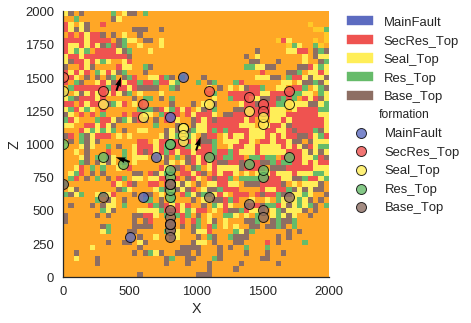

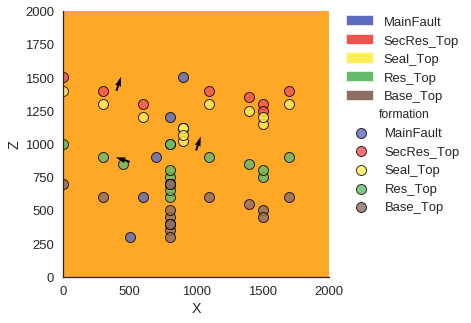

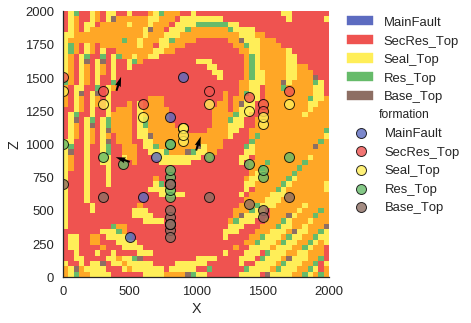

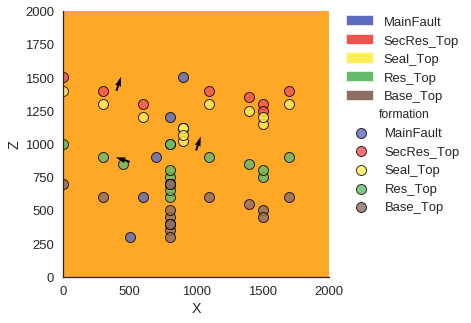

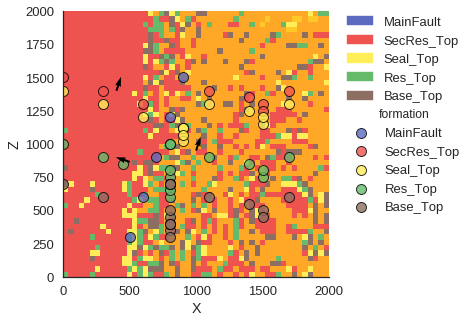

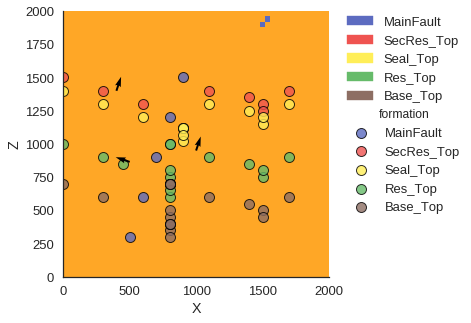

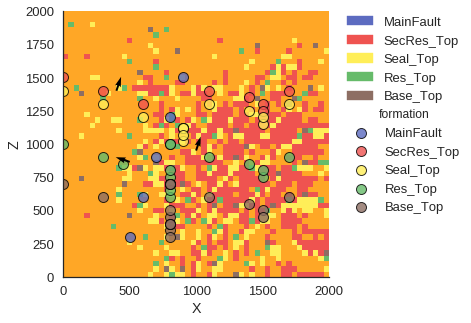

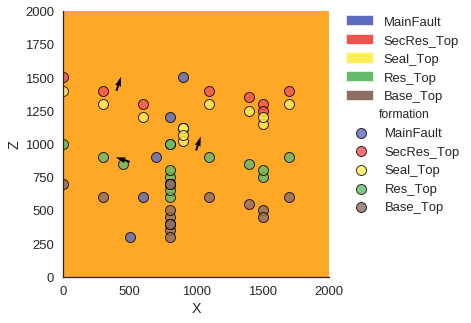

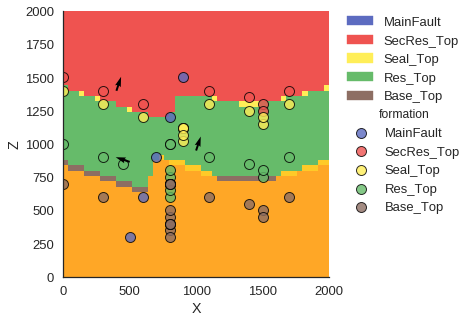

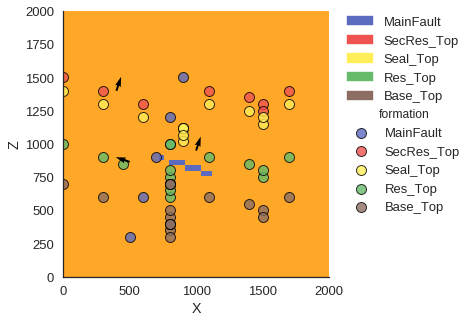

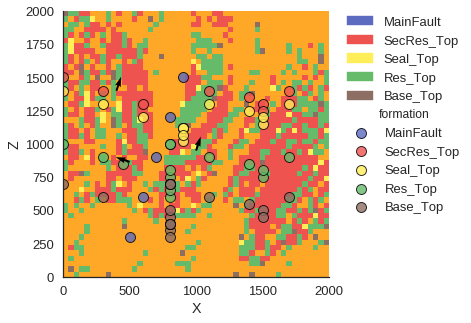

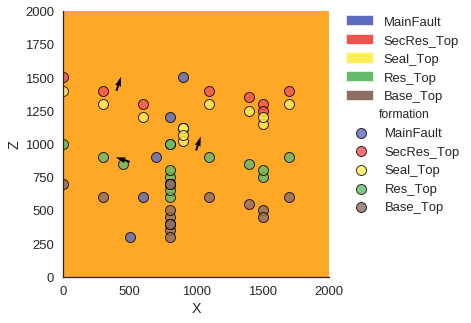

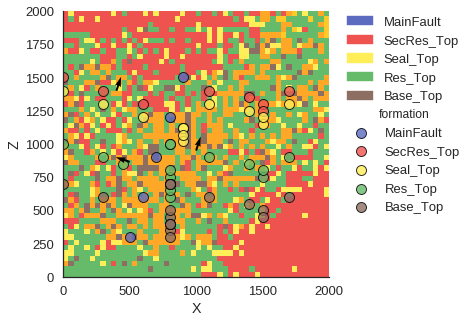

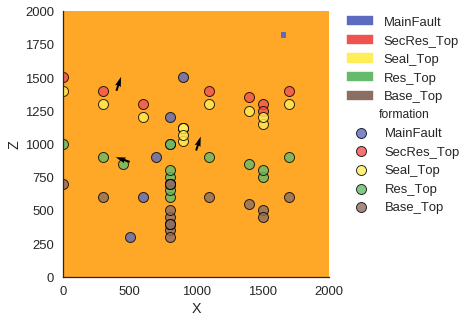

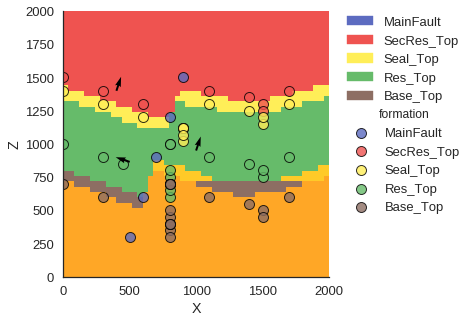

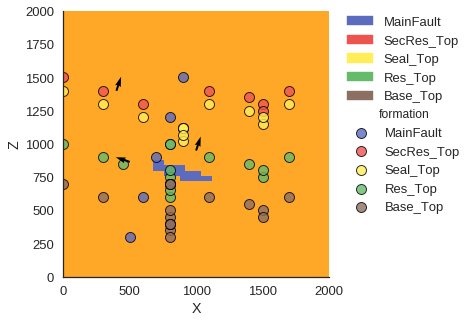

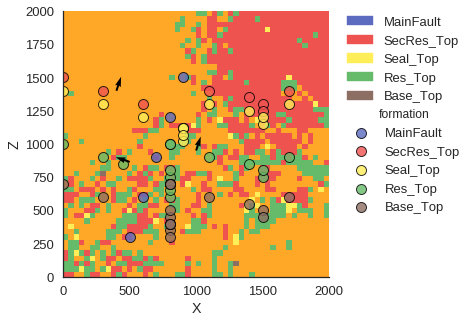

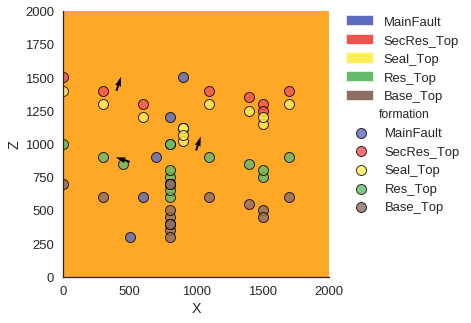

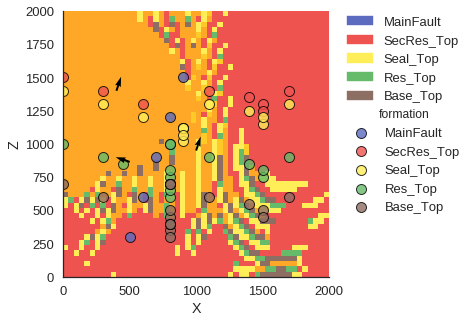

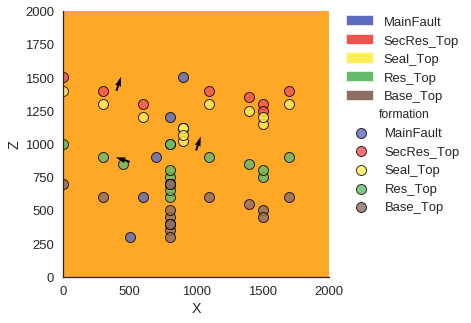

In [28]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

In [29]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

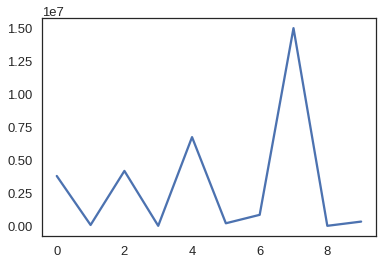

In [30]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

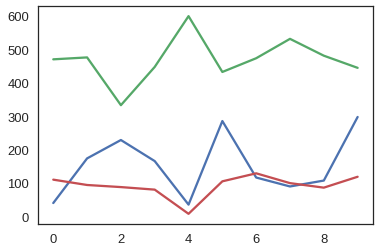

In [31]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

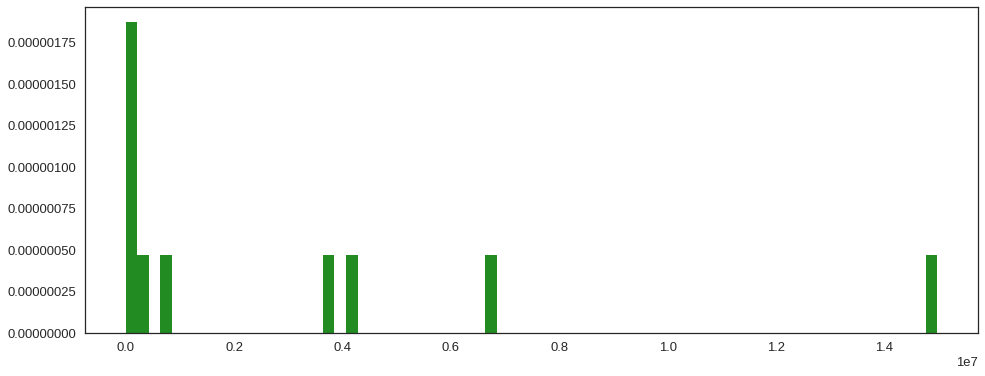

In [32]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [92]:
#import datetime
counter = 0
for i in structural_model_trace[:]:
    counter+=1
    #print(np.ascontiguousarray(i[3]))
    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/21_10B-TRAP_25iterUNC_LIKELIHOOD_%s" % (counter))
    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/21_10B-LITH_25iterUNC_LIKELIHOOD_%s" % (counter))

In [32]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

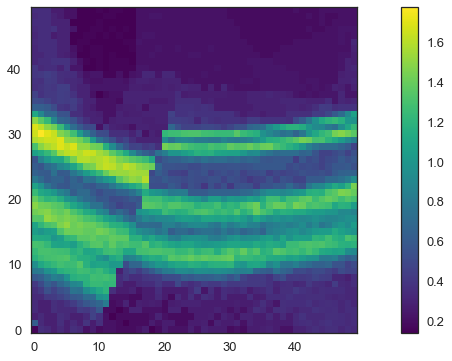

In [29]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [29]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

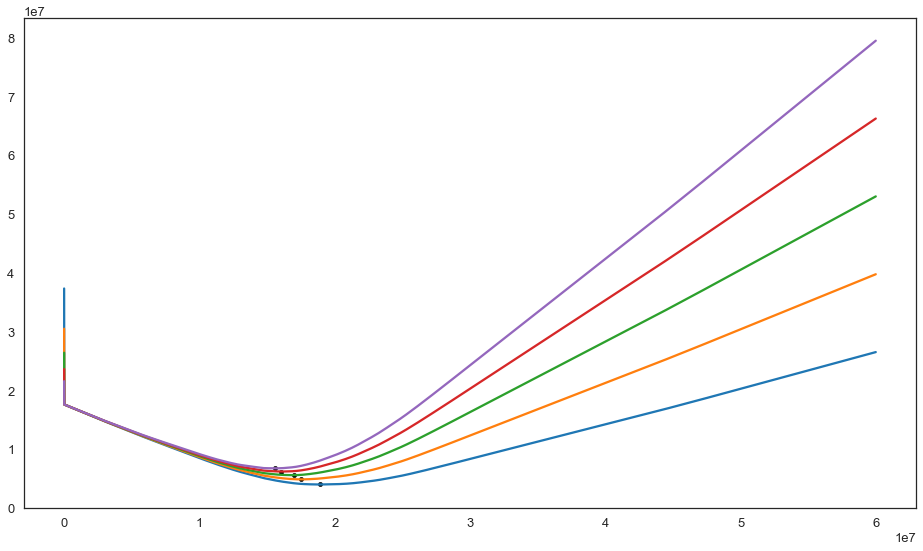

In [31]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [21]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 30
std3 = 20

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 400., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

In [22]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, 
                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [23]:
M_L = pymc.MCMC(model_L)
M_L.sample(iter=iterations, burn=50)

Z variations top to bottom: 3.11801360727 13.2517976803 -83.3496101246 19.005809101
Fault offset variation: -60.3935337497
Z variations top to bottom: 3.11801360727 44.0349923764 -83.3496101246 19.005809101
Fault offset variation: -60.3935337497
Z variations top to bottom: 4.19786719303 13.2517976803 -83.3496101246 19.005809101
Fault offset variation: -60.3935337497
Z variations top to bottom: 4.19786719303 13.2517976803 -83.3496101246 19.005809101
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 13.2517976803 26.521689205 19.005809101
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 13.2517976803 26.521689205 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom:

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to m

 4.19786719303 23.9501652699 26.521689205 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 1.42274086087 13.2517976803 26.521689205 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 13.2517976803 26.521689205 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 13.2517976803 26.521689205 18.1342522616
Fault offset variation: -132.249374084
Z variations top to bottom: 4.19786719303 13.2517976803 -2.31944692166 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 13.2517976803 -2.31944692166 -7.40382743236
Fault offset variation: -93.175600506
Z variations top to bottom: 4.19786719303 -0.648503380433 -2.31944692166 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 4.84623694116 -0.648503380433 -2.31944692166 18.1342522616
Fault offset variation: -93.175600506
Z variations top to bottom: 4.84623694116 -0.

Z variations top to bottom: 3.57030272405 -21.9501196125 20.7232823217 51.2494787437
Fault offset variation: -217.993994138
Z variations top to bottom: 3.57030272405 -21.9501196125 118.611148649 51.2494787437
Fault offset variation: -119.580101558
Z variations top to bottom: 3.57030272405 -21.9501196125 20.7232823217 51.2494787437
Fault offset variation: -119.580101558
Z variations top to bottom: 3.57030272405 -21.9501196125 20.7232823217 38.6615573134
Fault offset variation: -119.580101558
Z variations top to bottom: 3.57030272405 -31.1490328459 20.7232823217 38.6615573134
Fault offset variation: -119.580101558
Z variations top to bottom: 2.20062216029 -21.9501196125 20.7232823217 38.6615573134
Fault offset variation: -119.580101558
Z variations top to bottom: 2.20062216029 -21.9501196125 20.7232823217 38.6615573134
Fault offset variation: -190.674049006
Z variations top to bottom: 2.20062216029 -21.9501196125 14.0607487523 38.6615573134
Fault offset variation: -119.580101558
 [----- 

Fault offset variation: -93.6482456997
Z variations top to bottom: 2.50010003964 -15.6995786823 -20.0308141234 40.9378598229
Fault offset variation: -93.6482456997
Z variations top to bottom: 2.50010003964 -15.6995786823 -20.0308141234 40.9378598229
Fault offset variation: -60.2246333256
Z variations top to bottom: 2.50010003964 -15.6995786823 94.32204008 40.9378598229
Fault offset variation: -60.2246333256
Z variations top to bottom: 2.50010003964 -15.6995786823 -20.0308141234 47.3680876251
Fault offset variation: -60.2246333256
Z variations top to bottom: 2.50010003964 -9.33851444359 -20.0308141234 47.3680876251
Fault offset variation: -60.2246333256
Z variations top to bottom: -1.23199745515 -9.33851444359 -20.0308141234 47.3680876251
Fault offset variation: -60.2246333256
Z variations top to bottom: 2.50010003964 -9.33851444359 -20.0308141234 47.3680876251
Fault offset variation: -56.2518463623
Z variations top to bottom: 2.50010003964 -9.33851444359 82.3188404355 47.3680876251
Fau

Z variations top to bottom: -2.58238911611 -19.6945953441 -5.73195152484 47.4279595998
Fault offset variation: -26.4750727065
Z variations top to bottom: -2.58238911611 -30.9232781838 -5.73195152484 47.4279595998
Fault offset variation: -26.4750727065
Z variations top to bottom: -5.51789821908 -30.9232781838 -5.73195152484 47.4279595998
Fault offset variation: -26.4750727065
Z variations top to bottom: -5.51789821908 -30.9232781838 -5.73195152484 47.4279595998
Fault offset variation: -118.667353636
Z variations top to bottom: -5.51789821908 -30.9232781838 -31.6607238556 47.4279595998
Fault offset variation: -26.4750727065
 [-------------    36%                  ] 40 of 110 complete in 7.2 secZ variations top to bottom: -5.51789821908 -30.9232781838 -31.6607238556 66.4386840232
Fault offset variation: -26.4750727065
Z variations top to bottom: -5.51789821908 -42.7540022813 -31.6607238556 47.4279595998
Fault offset variation: -26.4750727065
Z variations top to bottom: -10.2262982632 -30.

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.0308402449173997e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 9 to overlying section 4.
Trap 9 is juxtaposed --> leaking
JP found Trap section 10 to overlying section 4.
Trap 10 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 15
JP found Trap section 18 to overlying section 16.
Trap 18 is juxtaposed --> leaking
Maximum reservoir volume: 7488000.0 m³
 [-----------------47%                  ] 52 of 110 complete in 12.1 secZ variations top to bottom: -8.02829760667 -34.9815497349 -14.3430679677 16.6398814624
Fault offset variation: -25.5699129786
Z variations top to bottom: -8.02829760667 -25.4784601096 -14.3430679677 16.6398814624
Fault offset variation: -25.5699129786
Z variations top to bottom: -10.2704506374 -25.4784601096 -14.3430679677 16.6398814624
Fault offset variation: -25.5699129786
Z variations top to bottom: -10.2704506374 -25.4784601096 -14.3430679677 16.6398814624
Fault offset variation: 36.8303346622
Z variations top to bottom: -10.2704506374 -25.4

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.182718194896794e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
Maximum reservoir volume: 24640000.0 m³
 [-----------------48%                  ] 53 of 110 complete in 14.9 secZ variations top to bottom: -10.2704506374 -25.4784601096 -7.72994281203 -29.6764245817
Fault offset variation: 36.8303346622
Z variations top to bottom: -10.2704506374 -21.0182340303 -7.72994281203 16.6398814624
Fault offset variation: 36.8303346622
Z variations top to bottom: -11.9160121666 -21.0182340303 -7.72994281203 16.6398814624
Fault offset variation: 36.8303346622
Z variations top to bottom: -11.9160121666 -21.0182340303 -7.72994281203 16.6398814624
Fault offset variation: 75.7282918098
Z variations top to bottom: -11.9160121666 -21.0182340303 -17.1912299223 16.6398814624
Fault offset variation: 75.7282918098
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1109501299743094e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 11
Maximum reservoir volume: 9216000.0 m³
 [-----------------49%                  ] 54 of 110 complete in 17.8 secZ variations top to bottom: -11.9160121666 -21.0182340303 -17.1912299223 13.2698080752
Fault offset variation: 75.7282918098
Z variations top to bottom: -11.9160121666 -17.5732634233 -17.1912299223 13.2698080752
Fault offset variation: 75.7282918098
Z variations top to bottom: -7.57792489091 -17.5732634233 -17.1912299223 13.2698080752
Fault offset variation: 75.7282918098
Z variations top to bottom: -7.57792489091 -17.5732634233 -17.1912299223 13.2698080752
Fault offset variation: 77.8122821032
Z variations top to bottom: -7.57792489091 -17.5732634233 -153.96463661 13.2698080752
Fault offset variation: 77.8122821032
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6895532242304787e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
JP found Trap section 9 to overlying section 5.
Trap 9 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 11
JP found Trap section 16 to overlying section 12.
JP found Trap section 16 to overlying section 13.
Trap 16 is juxtaposed --> leaking
JP found Trap section 17 to overlying section 12.
Trap 17 is juxtaposed --> leaking
Maximum reservoir volume: 18688000.0 m³
 [-----------------50%                  ] 55 of 110 complete in 20.6 secZ variations top to bottom: -7.57792489091 -17.5732634233 -17.1912299223 6.1418242244
Fault offset variation: 77.8122821032
Z variations top to bottom: -7.57792489091 -18.9524702594 -17.1912299223 13.2698080752
Fault offset variation: 77.8122821032
Z variations top to bottom: -11.4688869736 -18.9524702594 -17.1912299223 13.2698080752
Fault offset variation: 77.8122821032
Z variations top to bottom: -11.4688869736 -18.9524702594 -17.1912299223 13.2698080752
Fault offset variation: 97

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.039947771485901e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 152
No JP. TRAP FOUND, section: 160
No JP. TRAP FOUND, section: 162
No JP. TRAP FOUND, section: 164
No JP. TRAP FOUND, section: 167
No JP. TRAP FOUND, section: 169
No JP. TRAP FOUND, section: 170
No JP. TRAP FOUND, section: 174
No JP. TRAP FOUND, section: 178
No JP. TRAP FOUND, section: 180
No JP. TRAP FOUND, section: 183
No JP. TRAP FOUND, section: 184
No JP. TRAP FOUND, section: 191
No JP. TRAP FOUND, section: 194
No JP. TRAP FOUND, section: 195
No JP. TRAP FOUND, section: 196
No JP. TRAP FOUND, section: 200
No JP. TRAP FOUND, section: 202
No JP. TRAP FOUND, section: 204
No JP. TRAP FOUND, section: 206
No JP. TRAP FOUND, section: 216
No JP. TRAP FOUND, section: 218
No JP. TRAP FOUND, section: 230
No JP. TRAP FOUND, section: 235
No JP. TRAP FOUND, section: 237
No JP. TRAP FOUND, section: 242
No JP. TRAP FOUND, section: 252
No JP. TRAP FOUND, section: 254
No JP. TRAP FOUND, section: 255
No JP. TRAP F

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.595948883778827e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 11
Maximum reservoir volume: 25664000.0 m³
 [-----------------51%                  ] 57 of 110 complete in 27.2 secZ variations top to bottom: -12.4830394198 -18.9524702594 -29.2631381697 17.2719793551
Fault offset variation: 97.5416324302
Z variations top to bottom: -12.4830394198 -4.34695665028 -29.2631381697 17.2719793551
Fault offset variation: 97.5416324302
Z variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 17.2719793551
Fault offset variation: 97.5416324302
Z variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 17.2719793551
Fault offset variation: 25.3449004253
Z variations top to bottom: -10.5021842484 -18.9524702594 -123.109248163 17.2719793551
Fault offset variation: 25.3449004253
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6108921488400263e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
JP found Trap section 16 to overlying section 12.
JP found Trap section 16 to overlying section 13.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 15296000.0 m³
 [-----------------52%                  ] 58 of 110 complete in 30.1 secZ variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 34.3510983032
Fault offset variation: 25.3449004253
Z variations top to bottom: -10.5021842484 -13.7053470925 -29.2631381697 34.3510983032
Fault offset variation: 25.3449004253
Z variations top to bottom: -18.2248550594 -18.9524702594 -29.2631381697 34.3510983032
Fault offset variation: 25.3449004253
Z variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 34.3510983032
Fault offset variation: 25.3449004253
Z variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 34.3510983032
Fault offset variation: 24.4867360763
Z variations top to bottom: -10.5021842

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.198975376788148e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
Maximum reservoir volume: 13376000.0 m³
 [-----------------53%                  ] 59 of 110 complete in 33.0 secZ variations top to bottom: -10.5021842484 -18.9524702594 -29.2631381697 40.975301773
Fault offset variation: 24.4867360763
Z variations top to bottom: -10.5021842484 -34.3272687566 -29.2631381697 40.975301773
Fault offset variation: 24.4867360763
Z variations top to bottom: -9.52984031694 -34.3272687566 -29.2631381697 40.975301773
Fault offset variation: 24.4867360763
Z variations top to bottom: -9.52984031694 -34.3272687566 -29.2631381697 40.975301773
Fault offset variation: 55.024310405
Z variations top to bottom: -9.52984031694 -34.3272687566 52.7919353855 40.975301773
Fault offset variation: 55.024310405
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1141417649573881e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 12
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Fault SEALING, JP irrelevant. TRAP FOUND, section: 18
Maximum reservoir volume: 14976000.0 m³
 [-----------------54%                  ] 60 of 110 complete in 35.7 secZ variations top to bottom: -9.52984031694 -34.3272687566 -29.2631381697 50.2943556582
Fault offset variation: 55.024310405
Z variations top to bottom: -9.52984031694 -21.9633837303 -29.2631381697 40.975301773
Fault offset variation: 55.024310405
Z variations top to bottom: -8.22249098696 -21.9633837303 -29.2631381697 40.975301773
Fault offset variation: 55.024310405
Z variations top to bottom: -8.22249098696 -21.9633837303 -29.2631381697 40.975301773
Fault offset variation: 139.795450788
Z variations top to bottom: -8.22249098696 -21.9633837303 26.9273550427 40.975301773
Fault offset variation: 55.024310405
Z variations top to bottom: -8.22249098696 -21.9633

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3265442347018541e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
JP found Trap section 15 to overlying section 12.
JP found Trap section 15 to overlying section 13.
Trap 15 is juxtaposed --> leaking
Maximum reservoir volume: 17152000.0 m³
 [-----------------55%-                 ] 61 of 110 complete in 38.5 secZ variations top to bottom: -8.22249098696 -21.9633837303 -29.2631381697 53.0202798235
Fault offset variation: 55.024310405
Z variations top to bottom: -8.22249098696 -47.3156532182 -29.2631381697 53.0202798235
Fault offset variation: 55.024310405
Z variations top to bottom: -11.5962331762 -21.9633837303 -29.2631381697 53.0202798235
Fault offset variation: 55.024310405
Z variations top to bottom: -11.5962331762 -21.9633837303 -29.2631381697 53.0202798235
Fault offset variation: -14.9875945726
Z variations top to bottom: -11.5962331762 -21.9633837303 59.401686458 53.0202798235
Fault offset variation: -14.9875945726
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.30398543659206e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1090
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1099
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1145
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1172
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1184
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1194
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1275
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1295
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1306
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1314
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1331
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1354
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1357
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1375
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1388
Fault SEALING, JP irrelevant. TRAP FOUND, section: 1392
Fault SEALING, JP irrelevant. T

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.648795057599786e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Fault SEALING, JP irrelevant. TRAP FOUND, section: 17
Maximum reservoir volume: 10944000.0 m³
 [-----------------57%-                 ] 63 of 110 complete in 50.1 secZ variations top to bottom: -11.2549931189 -21.9633837303 -29.2631381697 7.80034796108
Fault offset variation: 51.2530611741
Z variations top to bottom: -11.2549931189 -9.53540130978 -29.2631381697 7.80034796108
Fault offset variation: 51.2530611741
Z variations top to bottom: -10.6490889926 -9.53540130978 -29.2631381697 7.80034796108
Fault offset variation: 51.2530611741
Z variations top to bottom: -10.6490889926 -9.53540130978 -29.2631381697 7.80034796108
Fault offset variation: 111.850659867
Z variations top to bottom: -10.6490889926 -9.53540130978 15.7500257685 7.80034796108
Fault offset variation: 111.850659867
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.824211268153242e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 11
JP found Trap section 16 to overlying section 12.
JP found Trap section 16 to overlying section 13.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 7168000.0 m³
 [-----------------58%--                ] 64 of 110 complete in 52.9 secZ variations top to bottom: -10.6490889926 -9.53540130978 -29.2631381697 8.35347392737
Fault offset variation: 111.850659867
Z variations top to bottom: -10.6490889926 -5.98828758853 -29.2631381697 8.35347392737
Fault offset variation: 111.850659867
Z variations top to bottom: -6.36329972568 -9.53540130978 -29.2631381697 8.35347392737
Fault offset variation: 111.850659867
Z variations top to bottom: -6.36329972568 -9.53540130978 -29.2631381697 8.35347392737
Fault offset variation: 79.3502690356
Z variations top to bottom: -6.36329972568 -9.53540130978 48.2717407255 8.35347392737
Fault offset variation: 79.3502690356
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.983151674901152e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Maximum reservoir volume: 13888000.0 m³
 [-----------------59%--                ] 65 of 110 complete in 55.8 secZ variations top to bottom: -6.36329972568 -9.53540130978 -29.2631381697 -1.61196860414
Fault offset variation: 79.3502690356
Z variations top to bottom: -6.36329972568 -6.55652845825 -29.2631381697 -1.61196860414
Fault offset variation: 79.3502690356
Z variations top to bottom: -9.74329436824 -6.55652845825 -29.2631381697 -1.61196860414
Fault offset variation: 79.3502690356
Z variations top to bottom: -6.36329972568 -6.55652845825 -29.2631381697 -1.61196860414
Fault offset variation: 8.24178395873
Z variations top to bottom: -6.36329972568 -6.55652845825 32.7261960704 -1.61196860414
Fault offset variation: 8.24178395873
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2034970023750445e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Maximum reservoir volume: 0 m³
 [-----------------60%--                ] 66 of 110 complete in 58.2 secZ variations top to bottom: -6.36329972568 -6.55652845825 -29.2631381697 3.85175005901
Fault offset variation: 8.24178395873
Z variations top to bottom: -6.36329972568 -10.8762583162 -29.2631381697 3.85175005901
Fault offset variation: 8.24178395873
Z variations top to bottom: -6.16494419445 -10.8762583162 -29.2631381697 3.85175005901
Fault offset variation: 8.24178395873
Z variations top to bottom: -6.16494419445 -10.8762583162 -29.2631381697 3.85175005901
Fault offset variation: 5.78239239022
Z variations top to bottom: -6.16494419445 -10.8762583162 23.8229885421 3.85175005901
Fault offset variation: 5.78239239022
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.5602801129176456e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 11
Maximum reservoir volume: 19584000.0 m³
 [-----------------60%---               ] 67 of 110 complete in 61.0 secZ variations top to bottom: -6.16494419445 -10.8762583162 -29.2631381697 -9.43665690052
Fault offset variation: 5.78239239022
Z variations top to bottom: -6.16494419445 -14.6650422357 -29.2631381697 -9.43665690052
Fault offset variation: 5.78239239022
Z variations top to bottom: -8.67031021812 -14.6650422357 -29.2631381697 -9.43665690052
Fault offset variation: 5.78239239022
Z variations top to bottom: -6.16494419445 -14.6650422357 -29.2631381697 -9.43665690052
Fault offset variation: -60.7210338712
Z variations top to bottom: -6.16494419445 -14.6650422357 -23.11826674 -9.43665690052
Fault offset variation: -60.7210338712
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3040145135576053e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 13
JP found Trap section 19 to overlying section 14.
JP found Trap section 19 to overlying section 15.
Trap 19 is juxtaposed --> leaking
Maximum reservoir volume: 19776000.0 m³
 [-----------------61%---               ] 68 of 110 complete in 63.9 secZ variations top to bottom: -6.16494419445 -14.6650422357 -23.11826674 6.04585824213
Fault offset variation: -60.7210338712
Z variations top to bottom: -6.16494419445 -5.65020871676 -23.11826674 6.04585824213
Fault offset variation: -60.7210338712
Z variations top to bottom: -5.40892169135 -14.6650422357 -23.11826674 6.04585824213
Fault offset variation: -60.7210338712
Z variations top to bottom: -5.40892169135 -14.6650422357 -23.11826674 6.04585824213
Fault offset variation: -29.7584675228
Z variations top to bottom: -5.40892169135 -14.6650422357 -24.723623058 6.04585824213

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1142327472079003e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 9 to overlying section 5.
Trap 9 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 12
Maximum reservoir volume: 18752000.0 m³
 [-----------------62%---               ] 69 of 110 complete in 66.7 secZ variations top to bottom: -5.40892169135 -14.6650422357 -24.723623058 -3.44339944052
Fault offset variation: -29.7584675228
Z variations top to bottom: -5.40892169135 -12.3347301993 -24.723623058 -3.44339944052
Fault offset variation: -29.7584675228
Z variations top to bottom: -7.78316279693 -12.3347301993 -24.723623058 -3.44339944052
Fault offset variation: -29.7584675228
Z variations top to bottom: -5.40892169135 -12.3347301993 -24.723623058 -3.44339944052
Fault offset variation: -210.051129841
Z variations top to bottom: -5.40892169135 -12.3347301993 -178.325839452 -3.44339944052
Fault offset variation: -29.7584675228
Z variations top to bottom: -5.40892169135 -12.3347301993 -24.723623058 -3.44339944052

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1338835135781661e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Maximum reservoir volume: 0 m³
 [-----------------63%----              ] 70 of 110 complete in 69.2 secZ variations top to bottom: -5.40892169135 -12.3347301993 -24.723623058 -11.2417759732
Fault offset variation: -29.7584675228
Z variations top to bottom: -5.40892169135 -26.7340167787 -24.723623058 -11.2417759732
Fault offset variation: -29.7584675228
Z variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 -11.2417759732
Fault offset variation: -29.7584675228
Z variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 -11.2417759732
Fault offset variation: -28.1140100361
Z variations top to bottom: -4.6396789133 -26.7340167787 99.5137464028 -11.2417759732
Fault offset variation: -28.1140100361
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6400886183008667e-13
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 13 to overlying section 5.
Trap 13 is juxtaposed --> leaking
JP found Trap section 16 to overlying section 14.
Trap 16 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------64%----              ] 71 of 110 complete in 72.1 secZ variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 4.02330767555
Fault offset variation: -28.1140100361
Z variations top to bottom: -4.6396789133 -30.3834831345 -24.723623058 4.02330767555
Fault offset variation: -28.1140100361
Z variations top to bottom: -12.4875492756 -26.7340167787 -24.723623058 4.02330767555
Fault offset variation: -28.1140100361
Z variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 4.02330767555
Fault offset variation: -28.1140100361
Z variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 4.02330767555
Fault offset variation: -53.6876149787
Z variations top to bottom: -4

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.248645264411712e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 12
Maximum reservoir volume: 13376000.0 m³
 [-----------------65%----              ] 72 of 110 complete in 75.0 secZ variations top to bottom: -4.6396789133 -26.7340167787 -24.723623058 -16.6826678953
Fault offset variation: -53.6876149787
Z variations top to bottom: -4.6396789133 -26.1047696512 -24.723623058 4.02330767555
Fault offset variation: -53.6876149787
Z variations top to bottom: -3.7414568898 -26.1047696512 -24.723623058 4.02330767555
Fault offset variation: -53.6876149787
Z variations top to bottom: -3.7414568898 -26.1047696512 -24.723623058 4.02330767555
Fault offset variation: -43.4466255368
Z variations top to bottom: -3.7414568898 -26.1047696512 -94.7025555052 4.02330767555
Fault offset variation: -43.4466255368
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.112450305014949e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 15 to overlying section 5.
Trap 15 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 24
No JP. TRAP FOUND, section: 25
No JP. TRAP FOUND, section: 28
Maximum reservoir volume: 192000.0 m³
 [-----------------66%-----             ] 73 of 110 complete in 77.8 secZ variations top to bottom: -3.7414568898 -26.1047696512 -24.723623058 16.7748106303
Fault offset variation: -43.4466255368
Z variations top to bottom: -3.7414568898 -10.7457859546 -24.723623058 16.7748106303
Fault offset variation: -43.4466255368
Z variations top to bottom: -1.37216478927 -26.1047696512 -24.723623058 16.7748106303
Fault offset variation: -43.4466255368
Z variations top to bottom: -1.37216478927 -26.1047696512 -24.723623058 16.7748106303
Fault offset variation: 40.1148946096
Z variations top to bottom: -1.37216478927 -26.1047696512 -8.79314105183 16.7748106303
Fault offset variation: 40.1148946096
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.33542178651458e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.


C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


JP found Trap section 8 to overlying section 5.
Trap 8 is juxtaposed --> leaking
JP found Trap section 9 to overlying section 5.
Trap 9 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 13
JP found Trap section 16 to overlying section 14.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 24512000.0 m³
 [-----------------67%-----             ] 74 of 110 complete in 80.7 secZ variations top to bottom: -1.37216478927 -26.1047696512 -24.723623058 11.3538018072
Fault offset variation: 40.1148946096
Z variations top to bottom: -1.37216478927 -38.3648742759 -24.723623058 11.3538018072
Fault offset variation: 40.1148946096
Z variations top to bottom: -2.67350221417 -26.1047696512 -24.723623058 11.3538018072
Fault offset variation: 40.1148946096
Z variations top to bottom: -2.67350221417 -26.1047696512 -24.723623058 11.3538018072
Fault offset variation: -14.1232494286
Z variations top to bottom: -2.67350221417 -26.1047696512 -158.621716 11.3538018072
Fault offset variation: -14.12

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4492110099513663e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Maximum reservoir volume: 26880000.0 m³
 [-----------------68%-----             ] 75 of 110 complete in 83.5 secZ variations top to bottom: -2.67350221417 -26.1047696512 -24.723623058 7.78498683366
Fault offset variation: -14.1232494286
Z variations top to bottom: -2.67350221417 -26.5982923876 -24.723623058 7.78498683366
Fault offset variation: -14.1232494286
Z variations top to bottom: -8.03188716664 -26.5982923876 -24.723623058 7.78498683366
Fault offset variation: -14.1232494286
Z variations top to bottom: -8.03188716664 -26.5982923876 -24.723623058 7.78498683366
Fault offset variation: -19.9445004321
Z variations top to bottom: -8.03188716664 -26.5982923876 -29.5537396699 7.78498683366
Fault offset variation: -19.9445004321
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.583887960706411e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
JP found Trap section 13 to overlying section 11.
Trap 13 is juxtaposed --> leaking
JP found Trap section 14 to overlying section 11.
Trap 14 is juxtaposed --> leaking
Maximum reservoir volume: 17280000.0 m³
 [-----------------69%------            ] 76 of 110 complete in 86.3 secZ variations top to bottom: -8.03188716664 -26.5982923876 -29.5537396699 6.19314034379
Fault offset variation: -19.9445004321
Z variations top to bottom: -8.03188716664 -44.4621590299 -29.5537396699 6.19314034379
Fault offset variation: -19.9445004321
Z variations top to bottom: -9.12066899075 -44.4621590299 -29.5537396699 6.19314034379
Fault offset variation: -19.9445004321
Z variations top to bottom: -9.12066899075 -44.4621590299 -29.5537396699 6.19314034379
Fault offset variation: -116.178040712
Z variations top to bottom: -9.12066899075 -44.4621590299 -155.671345927 6.19314034379
Fault offset variation: -19.9445004321


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7164912680399667e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Maximum reservoir volume: 17536000.0 m³
 [-----------------70%------            ] 77 of 110 complete in 89.2 secZ variations top to bottom: -9.12066899075 -44.4621590299 -29.5537396699 27.3193132573
Fault offset variation: -19.9445004321
Z variations top to bottom: -9.12066899075 -37.0355875778 -29.5537396699 27.3193132573
Fault offset variation: -19.9445004321
Z variations top to bottom: -4.74276382769 -37.0355875778 -29.5537396699 27.3193132573
Fault offset variation: -19.9445004321
Z variations top to bottom: -4.74276382769 -37.0355875778 -29.5537396699 27.3193132573
Fault offset variation: 30.5553307921
Z variations top to bottom: -4.74276382769 -37.0355875778 -67.8640879509 27.3193132573
Fault offset variation:

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4772245926497618e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 12
JP found Trap section 17 to overlying section 13.
JP found Trap section 17 to overlying section 14.
Trap 17 is juxtaposed --> leaking
Maximum reservoir volume: 19008000.0 m³
 [-----------------70%------            ] 78 of 110 complete in 92.0 secZ variations top to bottom: -4.74276382769 -37.0355875778 -29.5537396699 38.8666998424
Fault offset variation: 30.5553307921
Z variations top to bottom: -4.74276382769 -33.0731078627 -29.5537396699 38.8666998424
Fault offset variation: 30.5553307921
Z variations top to bottom: -5.32204284385 -33.0731078627 -29.5537396699 38.8666998424
Fault offset variation: 30.5553307921
Z variations top to bottom: -5.32204284385 -33.0731078627 -29.5537396699 38.8666998424
Fault offset variation: 20.4253126292
Z variations top to bottom: -5.32204284385 -33.0731078627 -60.8639376722 38.8666998424
Fault offset variation: 20.4253126292
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5989026075358126e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Maximum reservoir volume: 21376000.0 m³
 [-----------------71%-------           ] 79 of 110 complete in 94.9 secZ variations top to bottom: -5.32204284385 -33.0731078627 -29.5537396699 25.2828182274
Fault offset variation: 20.4253126292
Z variations top to bottom: -5.32204284385 -32.6438809296 -29.5537396699 25.2828182274
Fault offset variation: 20.4253126292
Z variations top to bottom: -12.714274138 -32.6438809296 -29.5537396699 25.2828182274
Fault offset variation: 20.4253126292
Z variations top to bottom: -12.714274138 -32.6438809296 -29.5537396699 25.2828182274
Fault offset variation: -21.2222891289
Z variations top to bottom: -12.714274138 -32.6438809296 -27.0657361949 25.2828182274
Fault offset variation: -21.2222891289
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.366000170927478e-13
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 18048000.0 m³
 [-----------------72%-------           ] 80 of 110 complete in 97.7 secZ variations top to bottom: -12.714274138 -32.6438809296 -27.0657361949 25.363030213
Fault offset variation: -21.2222891289
Z variations top to bottom: -12.714274138 -19.3164336422 -27.0657361949 25.363030213
Fault offset variation: -21.2222891289
Z variations top to bottom: -10.3434258297 -32.6438809296 -27.0657361949 25.363030213
Fault offset variation: -21.2222891289
Z variations top to bottom: -10.3434258297 -32.6438809296 -27.0657361949 25.363030213
Fault offset variation: -29.6013873998
Z variations top to bottom: -10.3434258297 -32.6438809296 61.4671776161 25.363030213
Fault offset variation: -29.6013873998
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.89288781759688e-14
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 11 to overlying section 5.
Trap 11 is juxtaposed --> leaking
JP found Trap section 14 to overlying section 12.
JP found Trap section 14 to overlying section 13.
Trap 14 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------73%-------           ] 81 of 110 complete in 100.5 secZ variations top to bottom: -10.3434258297 -32.6438809296 -27.0657361949 30.6160289358
Fault offset variation: -29.6013873998
Z variations top to bottom: -10.3434258297 -55.4271590993 -27.0657361949 30.6160289358
Fault offset variation: -29.6013873998
Z variations top to bottom: -6.90054674 -32.6438809296 -27.0657361949 30.6160289358
Fault offset variation: -29.6013873998
Z variations top to bottom: -6.90054674 -32.6438809296 -27.0657361949 30.6160289358
Fault offset variation: -9.97063409501
Z variations top to bottom: -6.90054674 -32.6438809296 -47.9286596717 30.6160289358
Fault offset varia

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2265366673702705e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 12
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Fault SEALING, JP irrelevant. TRAP FOUND, section: 16
Maximum reservoir volume: 26240000.0 m³
 [-----------------74%--------          ] 82 of 110 complete in 103.3 secZ variations top to bottom: -6.90054674 -32.6438809296 -47.9286596717 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -6.90054674 -43.1533347604 -47.9286596717 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -7.53256307962 -32.6438809296 -47.9286596717 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -7.53256307962 -32.6438809296 -47.9286596717 26.4539526376
Fault offset variation: 78.0184482184
Z variations top to bottom: -7.53256307962 -32.6438809296 133.862920323 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -7.53256307962 -

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6015557088665646e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 12
JP found Trap section 16 to overlying section 13.
Trap 16 is juxtaposed --> leaking
JP found Trap section 17 to overlying section 13.
Trap 17 is juxtaposed --> leaking
Maximum reservoir volume: 10880000.0 m³
 [-----------------75%--------          ] 83 of 110 complete in 106.2 secZ variations top to bottom: -7.53256307962 -32.6438809296 -47.9286596717 34.2699280518
Fault offset variation: -9.97063409501
Z variations top to bottom: -7.53256307962 -27.4121852753 -47.9286596717 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -4.48363327825 -27.4121852753 -47.9286596717 26.4539526376
Fault offset variation: -9.97063409501
Z variations top to bottom: -4.48363327825 -27.4121852753 -47.9286596717 26.4539526376
Fault offset variation: -69.9955170609
Z variations top to bottom: -4.48363327825 -27.4121852753 110.160884218 26.4539526376
Fault offset variation: -69.9955170609


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0184490730604558e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 342 to overlying section 5.
JP found Trap section 342 to overlying section 319.
JP found Trap section 342 to overlying section 349.
JP found Trap section 342 to overlying section 385.
JP found Trap section 342 to overlying section 387.
JP found Trap section 342 to overlying section 405.
JP found Trap section 342 to overlying section 406.
JP found Trap section 342 to overlying section 409.
JP found Trap section 342 to overlying section 427.
JP found Trap section 342 to overlying section 428.
JP found Trap section 342 to overlying section 429.
JP found Trap section 342 to overlying section 432.
JP found Trap section 342 to overlying section 460.
JP found Trap section 342 to overlying section 510.
JP found Trap section 342 to overlying section 534.
JP found Trap section 342 to overlying section 586.
JP found Trap section 342 to overlying section 629.
JP found Trap section 342 to overlying section 2.
JP found 

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0195765199071403e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
JP found Trap section 8 to overlying section 5.
Trap 8 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 12
JP found Trap section 19 to overlying section 13.
Trap 19 is juxtaposed --> leaking
Maximum reservoir volume: 25984000.0 m³
 [-----------------77%---------         ] 85 of 110 complete in 113.9 secZ variations top to bottom: 0.542550604607 -27.4121852753 -47.9286596717 15.7149671153
Fault offset variation: -69.9955170609
Z variations top to bottom: 0.542550604607 -45.6765896673 -47.9286596717 15.7149671153
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.41320913639 -27.4121852753 -47.9286596717 15.7149671153
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.41320913639 -27.4121852753 -47.9286596717 15.7149671153
Fault offset variation: -141.8540487
Z variations top to bottom: 1.41320913639 -27.41218

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4781778426815688e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)


Maximum reservoir volume: 0 m³
 [-----------------78%---------         ] 86 of 110 complete in 116.6 secZ variations top to bottom: 1.41320913639 -27.4121852753 -47.9286596717 -13.9321382276
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.41320913639 -32.5158058515 -47.9286596717 -13.9321382276
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.00068847166 -32.5158058515 -47.9286596717 -13.9321382276
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.00068847166 -32.5158058515 -47.9286596717 -13.9321382276
Fault offset variation: -123.174028936
Z variations top to bottom: 1.00068847166 -32.5158058515 -196.023479126 -13.9321382276
Fault offset variation: -69.9955170609
Z variations top to bottom: 1.00068847166 -32.5158058515 -47.9286596717 -13.9321382276
Fault offset variation: -69.9955170609
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.357721524403228e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 74
Fault SEALING, JP irrelevant. TRAP FOUND, section: 103
Fault SEALING, JP irrelevant. TRAP FOUND, section: 113
Fault SEALING, JP irrelevant. TRAP FOUND, section: 117
Fault SEALING, JP irrelevant. TRAP FOUND, section: 123
Fault SEALING, JP irrelevant. TRAP FOUND, section: 124
Fault SEALING, JP irrelevant. TRAP FOUND, section: 133
Fault SEALING, JP irrelevant. TRAP FOUND, section: 140
Fault SEALING, JP irrelevant. TRAP FOUND, section: 142
Fault SEALING, JP irrelevant. TRAP FOUND, section: 143
Fault SEALING, JP irrelevant. TRAP FOUND, section: 144
Fault SEALING, JP irrelevant. TRAP FOUND, section: 147
Fault SEALING, JP irrelevant. TRAP FOUND, section: 157
Fault SEALING, JP irrelevant. TRAP FOUND, section: 158
Fault SEALING, JP irrelevant. TRAP FOUND, section: 160
Fault SEALING, JP irrelevant. TRAP FOUND, section: 163
Fault SEALING, JP irrelevant. TRAP FOUND, section: 164
Fault S

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.02315838093614e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 12
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Fault SEALING, JP irrelevant. TRAP FOUND, section: 16
Fault SEALING, JP irrelevant. TRAP FOUND, section: 17
Fault SEALING, JP irrelevant. TRAP FOUND, section: 18
Maximum reservoir volume: 20544000.0 m³
 [-----------------80%----------        ] 88 of 110 complete in 122.8 secZ variations top to bottom: 1.95845210668 -30.5474745115 -47.9286596717 -5.12807537958
Fault offset variation: -112.627568937
Z variations top to bottom: 1.95845210668 -13.3532193486 -47.9286596717 -5.12807537958
Fault offset variation: -112.627568937
Z variations top to bottom: 5.78906508853 -13.3532193486 -47.9286596717 -5.12807537958
Fault offset variation: -112.627568937
Z variations top to bottom: 5.78906508853 -13.3532193486 -47.9286596717 -5.12807537958
Fault offset variation: -99.5349484583
Z variations top to bottom: 5.78906508853 -13.35321934

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.448441019902269e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 11 to overlying section 5.
Trap 11 is juxtaposed --> leaking
JP found Trap section 15 to overlying section 12.
JP found Trap section 15 to overlying section 13.
Trap 15 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------80%----------        ] 89 of 110 complete in 125.7 secZ variations top to bottom: 5.78906508853 -13.3532193486 -47.9286596717 -29.6451482795
Fault offset variation: -99.5349484583
Z variations top to bottom: 5.78906508853 -9.86509873803 -47.9286596717 -29.6451482795
Fault offset variation: -99.5349484583
Z variations top to bottom: 2.61284999103 -9.86509873803 -47.9286596717 -29.6451482795
Fault offset variation: -99.5349484583
Z variations top to bottom: 5.78906508853 -9.86509873803 -47.9286596717 -29.6451482795
Fault offset variation: -12.6316016592
Z variations top to bottom: 5.78906508853 -9.86509873803 -15.5607216688 -29.6451482795
Fault off

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1198780578157717e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
JP found Trap section 14 to overlying section 11.
JP found Trap section 14 to overlying section 12.
Trap 14 is juxtaposed --> leaking
Maximum reservoir volume: 22016000.0 m³
 [-----------------81%-----------       ] 90 of 110 complete in 128.5 secZ variations top to bottom: 5.78906508853 -9.86509873803 -15.5607216688 -20.3465325136
Fault offset variation: -12.6316016592
Z variations top to bottom: 5.78906508853 -15.5541873707 -15.5607216688 -20.3465325136
Fault offset variation: -12.6316016592
Z variations top to bottom: 6.30234044836 -15.5541873707 -15.5607216688 -20.3465325136
Fault offset variation: -12.6316016592
Z variations top to bottom: 6.30234044836 -15.5541873707 -15.5607216688 -20.3465325136
Fault offset variation: -4.40816193833
Z variations top to bottom: 6.30234044836 -15.5541873707 22.625513658 -20.3465325136
Fault offset variation: -4.40816193833
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.159240226536687e-13
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
JP found Trap section 16 to overlying section 12.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 19264000.0 m³
 [-----------------82%-----------       ] 91 of 110 complete in 131.3 secZ variations top to bottom: 6.30234044836 -15.5541873707 -15.5607216688 -15.3317883265
Fault offset variation: -4.40816193833
Z variations top to bottom: 6.30234044836 12.5934018707 -15.5607216688 -15.3317883265
Fault offset variation: -4.40816193833
Z variations top to bottom: 10.9794389283 -15.5541873707 -15.5607216688 -15.3317883265
Fault offset variation: -4.40816193833
Z variations top to bottom: 10.9794389283 -15.5541873707 -15.5607216688 -15.3317883265
Fault offset variation: -31.7507238295
Z variations top to bottom: 10.9794389283 -15.5541873707 -27.081183539 -15.3317883265
Fault offset variation: -31.7507238295
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2905462289103387e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 11
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Maximum reservoir volume: 18240000.0 m³
 [-----------------83%-----------       ] 92 of 110 complete in 134.2 secZ variations top to bottom: 10.9794389283 -15.5541873707 -27.081183539 -19.3462917328
Fault offset variation: -31.7507238295
Z variations top to bottom: 10.9794389283 -3.76268246646 -27.081183539 -15.3317883265
Fault offset variation: -31.7507238295
Z variations top to bottom: 8.88269451754 -3.76268246646 -27.081183539 -15.3317883265
Fault offset variation: -31.7507238295
Z variations top to bottom: 8.88269451754 -3.76268246646 -27.081183539 -15.3317883265
Fault offset variation: 23.6549728464
Z variations top to bottom: 8.88269451754 -3.76268246646 93.2347124979 -15.3317883265
Fault offset variation: 23.6549728464
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1599755878055618e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 17
Fault SEALING, JP irrelevant. TRAP FOUND, section: 18
Maximum reservoir volume: 13760000.0 m³
 [-----------------84%------------      ] 93 of 110 complete in 137.0 secZ variations top to bottom: 8.88269451754 -3.76268246646 -27.081183539 -9.76513212923
Fault offset variation: 23.6549728464
Z variations top to bottom: 8.88269451754 7.23097552888 -27.081183539 -9.76513212923
Fault offset variation: 23.6549728464
Z variations top to bottom: 8.68226111356 -3.76268246646 -27.081183539 -9.76513212923
Fault offset variation: 23.6549728464
Z variations top to bottom: 8.68226111356 -3.76268246646 -27.081183539 -9.76513212923
Fault offset variation: -8.92874056381
Z variations top to bottom: 8.68226111356 -3.76268246646 -1.11284283199 -9.76513212923
Fault offset variation: -8.92874056381
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.709067979990269e-13
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 11
JP found Trap section 15 to overlying section 12.
JP found Trap section 15 to overlying section 13.
Trap 15 is juxtaposed --> leaking
JP found Trap section 16 to overlying section 12.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 13184000.0 m³
 [-----------------85%------------      ] 94 of 110 complete in 139.8 secZ variations top to bottom: 8.68226111356 -3.76268246646 -27.081183539 -19.405338514
Fault offset variation: -8.92874056381
Z variations top to bottom: 8.68226111356 12.3807235191 -27.081183539 -19.405338514
Fault offset variation: -8.92874056381
Z variations top to bottom: 8.61187472998 -3.76268246646 -27.081183539 -19.405338514
Fault offset variation: -8.92874056381
Z variations top to bottom: 8.61187472998 -3.76268246646 -27.081183539 -19.405338514
Fault offset variation: -10.1370602028
Z v

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1169661347259644e-13
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 11
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Fault SEALING, JP irrelevant. TRAP FOUND, section: 16
Maximum reservoir volume: 9152000.0 m³
 [-----------------86%------------      ] 95 of 110 complete in 142.7 secZ variations top to bottom: 8.61187472998 -3.76268246646 -27.081183539 -45.0847970239
Fault offset variation: -10.1370602028
Z variations top to bottom: 8.61187472998 -23.4393197481 -27.081183539 -19.405338514
Fault offset variation: -10.1370602028
Z variations top to bottom: 6.1053915179 -23.4393197481 -27.081183539 -19.405338514
Fault offset variation: -10.1370602028
Z variations top to bottom: 6.1053915179 -23.4393197481 -27.081183539 -19.405338514
Fault offset variation: 46.1095560239
Z variations top to bottom: 6.1053915179 -23.4393197481 135.040195401 -19.405338514
Fault offset variation: -10.1370602028
Z variations top to bottom: 6.1053915179 -23.43931

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1112354919861076e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
JP found Trap section 14 to overlying section 12.
Trap 14 is juxtaposed --> leaking
JP found Trap section 16 to overlying section 12.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 18112000.0 m³
 [-----------------87%-------------     ] 96 of 110 complete in 145.6 secZ variations top to bottom: 6.1053915179 -23.4393197481 -27.081183539 -24.6257905347
Fault offset variation: -10.1370602028
Z variations top to bottom: 6.1053915179 -38.222490244 -27.081183539 -19.405338514
Fault offset variation: -10.1370602028
Z variations top to bottom: 8.22251036021 -23.4393197481 -27.081183539 -19.405338514
Fault offset variation: -10.1370602028
Z variations top to bottom: 8.22251036021 -23.4393197481 -27.081183539 -19.405338514
Fault offset variation: -96.6746582835
Z variations top to bottom: 8.22251036021 -23.4393197481 148.67793763 -19.405338514
Fault offset variation: -10.1370602028
Z variations

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.5382933602213775e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 13
Maximum reservoir volume: 18112000.0 m³
 [-----------------88%-------------     ] 97 of 110 complete in 148.4 secZ variations top to bottom: 8.22251036021 -23.4393197481 -27.081183539 -10.2126858959
Fault offset variation: -10.1370602028
Z variations top to bottom: 8.22251036021 -41.2438873778 -27.081183539 -10.2126858959
Fault offset variation: -10.1370602028
Z variations top to bottom: 4.73002970707 -23.4393197481 -27.081183539 -10.2126858959
Fault offset variation: -10.1370602028
Z variations top to bottom: 4.73002970707 -23.4393197481 -27.081183539 -10.2126858959
Fault offset variation: -7.90173195047
Z variations top to bottom: 4.73002970707 -23.4393197481 -7.55580588103 -10.2126858959
Fault offset variation: -7.90173195047
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.5619327839732087e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
JP found Trap section 14 to overlying section 11.
Trap 14 is juxtaposed --> leaking
JP found Trap section 15 to overlying section 11.
Trap 15 is juxtaposed --> leaking
JP found Trap section 16 to overlying section 11.
JP found Trap section 16 to overlying section 12.
Trap 16 is juxtaposed --> leaking
Maximum reservoir volume: 25280000.0 m³
 [-----------------89%-------------     ] 98 of 110 complete in 151.1 secZ variations top to bottom: 4.73002970707 -23.4393197481 -27.081183539 7.9344936431
Fault offset variation: -7.90173195047
Z variations top to bottom: 4.73002970707 -42.9612591619 -27.081183539 7.9344936431
Fault offset variation: -7.90173195047
Z variations top to bottom: 5.10629144199 -23.4393197481 -27.081183539 7.9344936431
Fault offset variation: -7.90173195047
Z variations top to bottom: 5.10629144199 -23.4393197481 -27.081183539 7.9344936431
Fault offset variation: 65.5939376944
Z va

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.3572788526478075e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 10
JP found Trap section 14 to overlying section 11.
JP found Trap section 14 to overlying section 12.
Trap 14 is juxtaposed --> leaking
Maximum reservoir volume: 20224000.0 m³
 [-----------------90%--------------    ] 99 of 110 complete in 153.8 secZ variations top to bottom: 5.10629144199 -23.4393197481 -21.324799476 12.3792675804
Fault offset variation: 65.5939376944
Z variations top to bottom: 5.10629144199 -27.4508971059 -21.324799476 12.3792675804
Fault offset variation: 65.5939376944
Z variations top to bottom: -0.767749895642 -23.4393197481 -21.324799476 12.3792675804
Fault offset variation: 65.5939376944
Z variations top to bottom: -0.767749895642 -23.4393197481 -21.324799476 12.3792675804
Fault offset variation: -8.25999032584
Z variations top to bottom: -0.767749895642 -23.4393197481 -48.0315580919 12.3792675804
Fault offset variation: -8.25999032584
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.200225848210003e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 12
Maximum reservoir volume: 25856000.0 m³
 [-----------------90%--------------    ] 100 of 110 complete in 156.5 secZ variations top to bottom: -0.767749895642 -23.4393197481 -21.324799476 23.884029651
Fault offset variation: -8.25999032584
Z variations top to bottom: -0.767749895642 22.6286377814 -21.324799476 23.884029651
Fault offset variation: -8.25999032584
Z variations top to bottom: -2.45817822603 -23.4393197481 -21.324799476 23.884029651
Fault offset variation: -8.25999032584
Z variations top to bottom: -2.45817822603 -23.4393197481 -21.324799476 23.884029651
Fault offset variation: -22.7819366856
Z variations top to bottom: -2.45817822603 -23.4393197481 -30.7001315552 23.884029651
Fault offset variation: -22.7819366856
Fault sealing = True


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3156603627731411e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 11
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Fault SEALING, JP irrelevant. TRAP FOUND, section: 16
Maximum reservoir volume: 17152000.0 m³
 [-----------------91%--------------    ] 101 of 110 complete in 159.3 secZ variations top to bottom: -2.45817822603 -23.4393197481 -30.7001315552 34.8198091973
Fault offset variation: -22.7819366856
Z variations top to bottom: -2.45817822603 -36.052933065 -30.7001315552 34.8198091973
Fault offset variation: -22.7819366856
Z variations top to bottom: -4.81511911861 -23.4393197481 -30.7001315552 34.8198091973
Fault offset variation: -22.7819366856
Z variations top to bottom: -4.81511911861 -23.4393197481 -30.7001315552 34.8198091973
Fault offset variation: -29.2404970111
Z variations top to bottom: -4.81511911861 -23.4393197481 0.127645505063 34.8198091973
Fault offset variatio

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8416467742493224e-15
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 58
JP found Trap section 59 to overlying section 6.
Trap 59 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 63
No JP. TRAP FOUND, section: 75
No JP. TRAP FOUND, section: 86
No JP. TRAP FOUND, section: 91
JP found Trap section 95 to overlying section 57.
Trap 95 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 98
No JP. TRAP FOUND, section: 99
No JP. TRAP FOUND, section: 100
No JP. TRAP FOUND, section: 104
Maximum reservoir volume: 15872000.0 m³
 [-----------------92%---------------   ] 102 of 110 complete in 162.2 secZ variations top to bottom: -4.81511911861 -23.4393197481 -30.7001315552 31.4531959732
Fault offset variation: -29.2404970111
Z variations top to bottom: -4.81511911861 -20.72725437 -30.7001315552 31.4531959732
Fault offset variation: -29.2404970111
Z variations top to bottom: -9.49859766233 -20.72725437 -30.7001315552 31.4531959732
Fault offset variation: -29.2404970111
Z var

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0643143484589945e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Fault SEALING, JP irrelevant. TRAP FOUND, section: 14
Fault SEALING, JP irrelevant. TRAP FOUND, section: 15
Fault SEALING, JP irrelevant. TRAP FOUND, section: 17
Maximum reservoir volume: 28288000.0 m³
 [-----------------93%---------------   ] 103 of 110 complete in 164.9 secZ variations top to bottom: -4.81511911861 -20.72725437 -30.7001315552 30.255530582
Fault offset variation: 38.4389693157
Z variations top to bottom: -4.81511911861 -25.1435158614 -30.7001315552 30.255530582
Fault offset variation: 38.4389693157
Z variations top to bottom: -3.64519776627 -25.1435158614 -30.7001315552 30.255530582
Fault offset variation: 38.4389693157
Z variations top to bottom: -3.64519776627 -25.1435158614 -30.7001315552 30.255530582
Fault offset variation: 16.1343264918
Z variations top to bottom: -3.64519776627 -25.1435158614 -39.2

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.9182223084251993e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 11
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Fault SEALING, JP irrelevant. TRAP FOUND, section: 18
Maximum reservoir volume: 14656000.0 m³
 [-----------------94%---------------   ] 104 of 110 complete in 167.6 secZ variations top to bottom: -3.64519776627 -25.1435158614 -30.7001315552 27.6879581941
Fault offset variation: 16.1343264918
Z variations top to bottom: -3.64519776627 -29.5491373857 -30.7001315552 27.6879581941
Fault offset variation: 16.1343264918
Z variations top to bottom: -0.817783361618 -29.5491373857 -30.7001315552 27.6879581941
Fault offset variation: 16.1343264918
Z variations top to bottom: -0.817783361618 -29.5491373857 -30.7001315552 27.6879581941
Fault offset variation: -17.1138424795
Z variations top to bottom: -0.817783361618 -29.5491373857 -17.3224985638 27.6879581941
Fault offset variation: -17.1138424795
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.767883491849865e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 11
JP found Trap section 15 to overlying section 12.
Trap 15 is juxtaposed --> leaking
Maximum reservoir volume: 21120000.0 m³
 [-----------------95%----------------  ] 105 of 110 complete in 170.3 secZ variations top to bottom: -0.817783361618 -29.5491373857 -17.3224985638 22.3939876611
Fault offset variation: -17.1138424795
Z variations top to bottom: -0.817783361618 -50.4400702584 -17.3224985638 22.3939876611
Fault offset variation: -17.1138424795
Z variations top to bottom: -4.45531513149 -29.5491373857 -17.3224985638 22.3939876611
Fault offset variation: -17.1138424795
Z variations top to bottom: -4.45531513149 -29.5491373857 -17.3224985638 22.3939876611
Fault offset variation: -92.3348047066
Z variations top to bottom: -4.45531513149 -29.5491373857 28.3598381593 22.3939876611
Fault offset variation: -92.3348047066
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4931501307889903e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
JP found Trap section 8 to overlying section 5.
Trap 8 is juxtaposed --> leaking
JP found Trap section 14 to overlying section 5.
Trap 14 is juxtaposed --> leaking
JP found Trap section 17 to overlying section 15.
JP found Trap section 17 to overlying section 16.
Trap 17 is juxtaposed --> leaking
JP found Trap section 20 to overlying section 15.
JP found Trap section 20 to overlying section 16.
Trap 20 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------96%----------------  ] 106 of 110 complete in 173.2 secZ variations top to bottom: -4.45531513149 -29.5491373857 -17.3224985638 30.410370362
Fault offset variation: -92.3348047066
Z variations top to bottom: -4.45531513149 -23.3616059545 -17.3224985638 30.410370362
Fault offset variation: -92.3348047066
Z variations top to bottom: -7.00980819062 -23.361605

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2655375839231162e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Fault SEALING, JP irrelevant. TRAP FOUND, section: 13
Maximum reservoir volume: 16448000.0 m³
 [-----------------97%----------------  ] 107 of 110 complete in 176.1 secZ variations top to bottom: -7.00980819062 -23.3616059545 -17.3224985638 24.3628585916
Fault offset variation: 34.4267990116
Z variations top to bottom: -7.00980819062 -20.2896938308 -17.3224985638 24.3628585916
Fault offset variation: 34.4267990116
Z variations top to bottom: -6.88684014128 -20.2896938308 -17.3224985638 24.3628585916
Fault offset variation: 34.4267990116
Z variations top to bottom: -6.88684014128 -20.2896938308 -17.3224985638 24.3628585916
Fault offset variation: 75.3834544359
Z variations top to bottom: -6.88684014128 -20.2896938308 -99.4060336 24.3628585916
Fault offset variation: 75.3834544359
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5641184528125684e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 11
Maximum reservoir volume: 22272000.0 m³
 [-----------------98%----------------- ] 108 of 110 complete in 178.9 secZ variations top to bottom: -6.88684014128 -20.2896938308 -17.3224985638 9.18894942928
Fault offset variation: 75.3834544359
Z variations top to bottom: -6.88684014128 -24.3572670351 -17.3224985638 9.18894942928
Fault offset variation: 75.3834544359
Z variations top to bottom: -2.69284288324 -24.3572670351 -17.3224985638 9.18894942928
Fault offset variation: 75.3834544359
Z variations top to bottom: -2.69284288324 -24.3572670351 -17.3224985638 9.18894942928
Fault offset variation: 92.6754405903
Z variations top to bottom: -2.69284288324 -24.3572670351 106.828186219 9.18894942928
Fault offset variation: 92.6754405903
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.407766030872025e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
JP found Trap section 7 to overlying section 5.
Trap 7 is juxtaposed --> leaking
JP found Trap section 9 to overlying section 5.
Trap 9 is juxtaposed --> leaking
No JP. TRAP FOUND, section: 13
JP found Trap section 15 to overlying section 12.
Trap 15 is juxtaposed --> leaking
JP found Trap section 17 to overlying section 12.
JP found Trap section 17 to overlying section 14.
Trap 17 is juxtaposed --> leaking
Maximum reservoir volume: 6528000.0 m³
 [-----------------99%----------------- ] 109 of 110 complete in 181.7 secZ variations top to bottom: -2.69284288324 -24.3572670351 -17.3224985638 -5.40117936755
Fault offset variation: 92.6754405903
Z variations top to bottom: -2.69284288324 -27.6074744458 -17.3224985638 9.18894942928
Fault offset variation: 92.6754405903
Z variations top to bottom: -1.29271838043 -27.6074744458 -17.3224985638 9.18894942928
Fault offset variation: 92.6754405903
Z variations top to bottom: -

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.471514143116376e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 19
No JP. TRAP FOUND, section: 20
JP found Trap section 26 to overlying section 16.
JP found Trap section 26 to overlying section 18.
Trap 26 is juxtaposed --> leaking
Maximum reservoir volume: 2432000.0 m³
 [-----------------100%-----------------] 110 of 110 complete in 184.7 secZ variations top to bottom: -1.29271838043 -27.6074744458 -17.3224985638 -7.44104426744
Fault offset variation: 92.6754405903
Z variations top to bottom: -1.29271838043 -36.8723041149 -17.3224985638 9.18894942928
Fault offset variation: 92.6754405903
Z variations top to bottom: -3.42441783875 -27.6074744458 -17.3224985638 9.18894942928
Fault offset variation: 92.6754405903
Z variations top to bottom: -3.42441783875 -27.6074744458 -17.3224985638 9.18894942928
Fault offset variation: 88.1838235287
Z variations top to bottom: -3.42441783875 -27.6074744458 -76.9032001215 9.18894942928
Fault offset variation: 88.18382

C:\Users\Fabian\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1563647175222291e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
No JP. TRAP FOUND, section: 11
JP found Trap section 15 to overlying section 12.
JP found Trap section 15 to overlying section 13.
Trap 15 is juxtaposed --> leaking
Maximum reservoir volume: 16192000.0 m³
 [-----------------100%-----------------] 111 of 110 complete in 187.5 sec

In [24]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

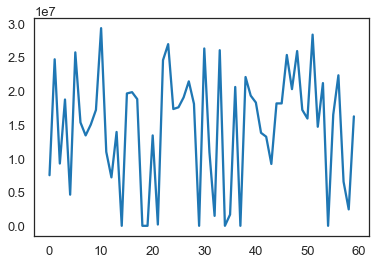

In [25]:
max_volume_trace_L = structural_model_trace_L[:,2]
plt.plot(max_volume_trace_L)

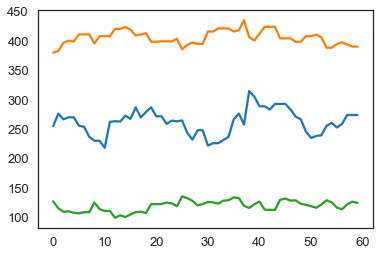

In [26]:
plt.plot(fw_res_th_trace_L)
plt.plot(fw_seal_th_trace_L)
plt.plot(fw_sec_res_th_trace_L)

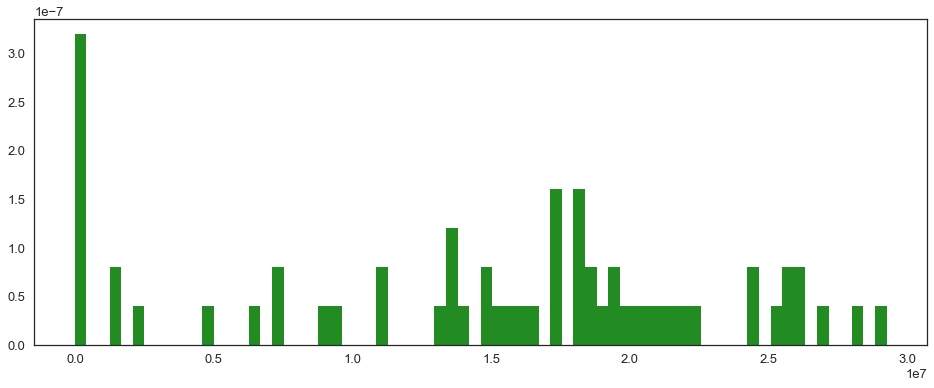

In [27]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace_L
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace_L, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

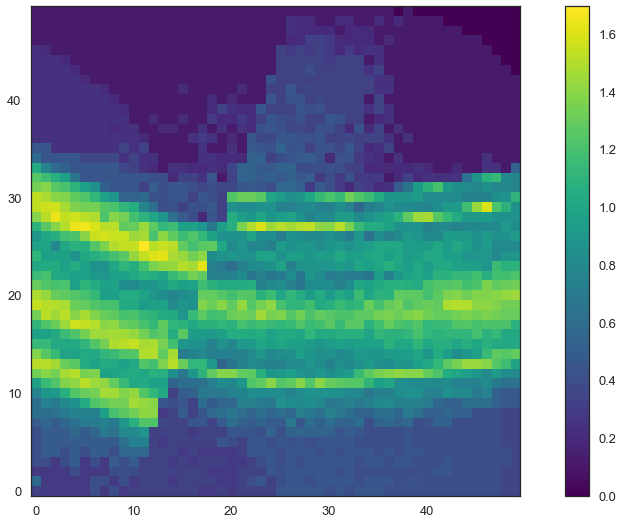

In [44]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

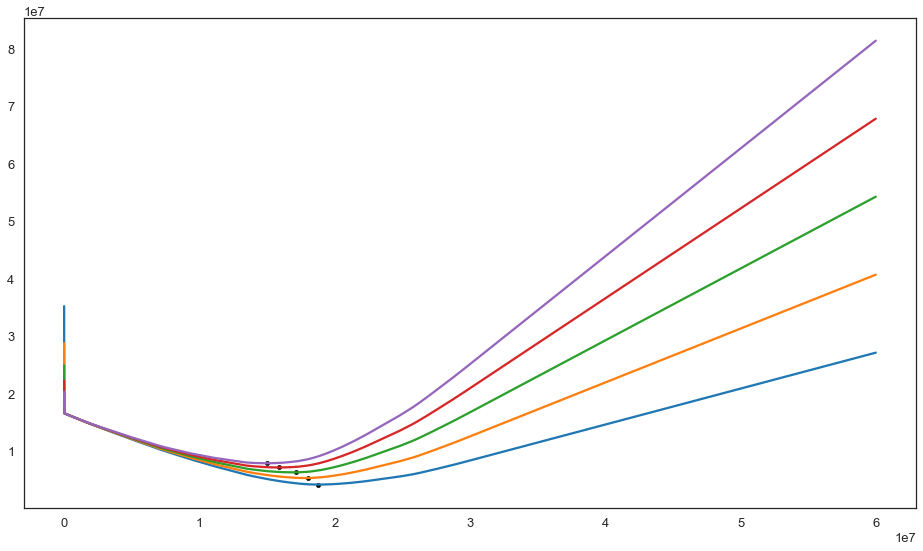

In [30]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [12]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [206]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)

In [248]:
#a,b = np.gradient(grid_z0, 40.81632614)
#a = np.rot90(a,-1)
#
#asign = np.sign(a)
#asignchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
#
##print(asignchange)
#asignchange2 = ((np.roll(asign, -1) - asign) != 0).astype(int)
#
#
#asc3 = np.logical_or(asignchange, asignchange2)
#
#asc3[:,0]= 0
#asc3[:,1]= 0
#asc3[:,-1] = 0
#asc3[-1,:] = 0
#print(asc3)
#
#bsign = np.sign(b)
#bsignchange = ((np.roll(bsign, 1) - bsign) != 0).astype(int)
#bsignchange2 = ((np.roll(bsign, -1) - bsign) != 0).astype(int)
#
#bsc3 = np.logical_or(bsignchange, bsignchange2)
#
#bsc3[:,0]= 0
#bsc3[:,-1] = 0
#bsc3[:,-2] = 0
#bsc3[:,-3] = 0
#bsc3[-1,:] = 0
##print(bsignchange)
#
#
#asignchange = np.rot90(asignchange,1)
#asc3 = np.rot90(asc3,1)
#
#c = np.logical_and(asc3,bsc3)

[[False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False False  True
   True False]
 [False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False

In [333]:
#grad_zero = saddle_p_all == 1
#grid_z0[~grad_zero]= np.nan
#grid_z0

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,

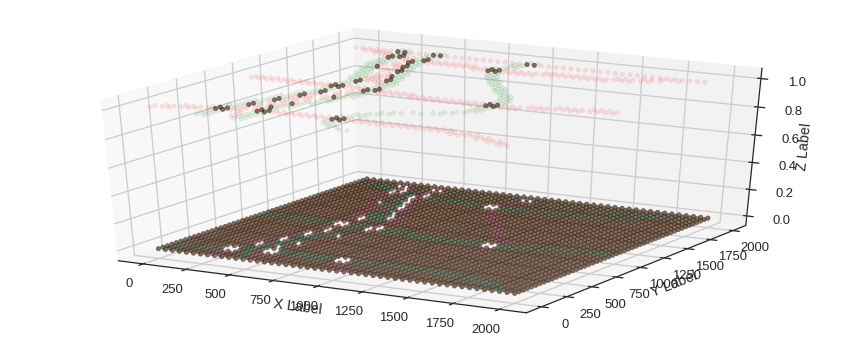

In [249]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, asc3, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, c, c="black", alpha = 0.5)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

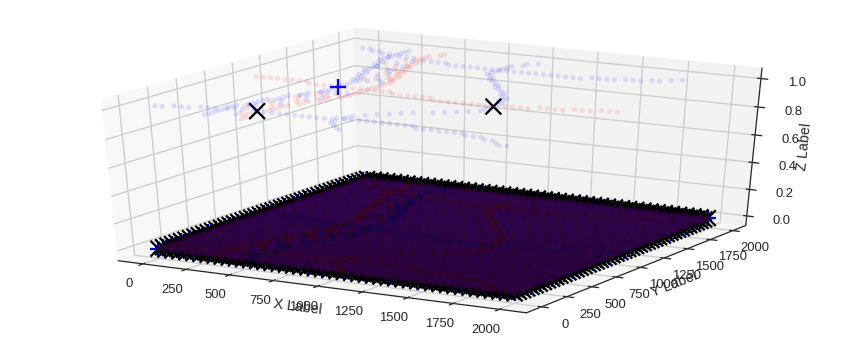

In [372]:
#fault_line = grid_minX[grid_maxX]
#figsize(15,6)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, spill_points, c="black", alpha = 1, marker='x', s = 250)
#ax.scatter(grid_x, grid_y, leak_point, c="b", alpha = 1, marker='+', s= 250)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

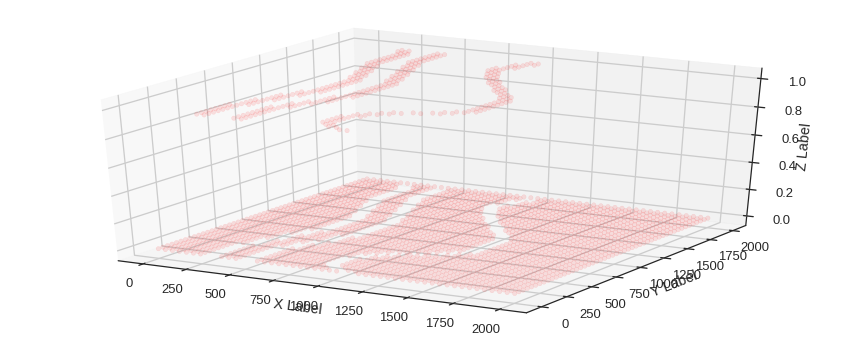

In [245]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -a, c="r", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -asignchange, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="r", alpha = 0.1)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

In [38]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
#def spill_point(res_surface):
#    mini = argrelextrema(res_surface[:,2], np.less, order=10)
#    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
#    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
#    spill_min_line = minima[fault_thresh]
#    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
#    spill_z = np.take(spill_min_line[:,2], spill_pos)
#    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
#                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
#    
#    # Horizontal plane defined by z-pos of spill
#    if True:
#        spill_bottom = np.ones_like(res_surface)
#        spill_bottom[:,0] = res_surface[:,0]
#        spill_bottom[:,1] = res_surface[:,1]
#        spill_bottom[:,2] = spill_z    
#    
#    return spill_z, spill_p, spill_min_line, spill_bottom
#
## Finding the leak point ( critically inefficient method! takes 10s!)
#def leak_point(res_surface):
#    counter = 0
#    # Creating empty lists and arrays to save values
#    xvals = []
#    yvals = []
#    zvals = []
#    leak_min = np.empty((0,3), dtype=int)
#    #leak_min = np.empty([3,], dtype=int)
#    
#    for i in np.unique(res_surface[:,1]):
#        
#    #while counter < model_size:
#        #print(counter)
#        for e in res_surface:
#            # Looking at a slice along y-axis for y = e[1] = counter, 
#            # and appending x,y,z-values into lists
#            # This is a way of RESORTING the array as needed
#            #if int(e[1]) == counter:
#            if e[1] == i:
#                xvals.append(e[0])
#                yvals.append(e[1])
#                zvals.append(e[2])
#            
#        # Saving x,y,z-values as lists/arrays      
#        zvals = np.array(zvals)
#        yvals = np.array(yvals)
#        xvals = np.array(xvals)
#
#        # Looking fore minima positions in z-array
#        min_pos = argrelextrema(zvals, np.less, order=10)
#        
#        # Saving x,y,z-positions of minima
#        ypos = yvals[min_pos]
#        xpos = xvals[min_pos]
#        mins = zvals[min_pos]
#        
#        # Condition: Check if any minimum was found and if any data is given at y = counter
#        # If no minimum found, restart loop at next iteration
#        # This way, we can work with the data that coesn't cover every 1 step along the model
#        # (such as the surface vertices)
#        if len(mins) == 0:
#            counter += 1
#            #lists have to be emptied again
#            xvals = []
#            yvals = []
#            zvals = []
#            continue
#        
#        #np.append(leak_min, mins) -----> what did I use this for?
#        
#        # Create and array element to save coordinates of minima
#        mins_pos = np.array(list(zip(xpos, ypos, mins)))
#        # Save minima of slice into array of ALL minima
#        leak_min = np.vstack((leak_min, mins_pos))
#
#        # Empty lists for next iteration
#        xvals = []
#        yvals = []
#        zvals = []
#    
#        counter += 1
#        
#    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
#    
#    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
#    # only want to look at the line bordering the fault surface
#    # need for a general function/method to limit to only that line!
#    # For now: Taking only relevant side by setting a threshold that is visually estimated
#    near_fault_thresh = leak_min[:,0] < 1500
#    leak_line = leak_min[near_fault_thresh]
#    
#    # The highest point of the leak line is the leak point!
#    leak_pos = np.array(np.argmax(leak_line[:,2]))
#    leak_z = np.take(leak_line[:,2], leak_pos)
#
#    # Full coordinates of the leak point as array element
#    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
#    
#    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
#    leak_bottom = np.ones_like(res_surface)
#    leak_bottom[:,0] = res_surface[:,0]
#    leak_bottom[:,1] = res_surface[:,1]
#    leak_bottom[:,2] = leak_z
#   
#    return leak_z, leak_p, leak_line, leak_bottom

### PLOTTING SP, LP and TRAP
#def plot_spill(res_surface, spill_min_line, spill_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#
#    plt.show()
#
#def plot_leak(res_surface, leak_line, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()
#    
#def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)
#
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()